### SUPERVISED LEARNING

In [1]:
# Add the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.feather as feather
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f_oneway

### Prepare the data for supervised learning

In [2]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Path to your Feather file
file_path = 'df_temp.feather'

# Read the Feather file into a DataFrame
df = pd.DataFrame(feather.read_feather(file_path))

df

,category,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,intermediate,2000-03-31,2000,1,-0.320295,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.338976,-0.072202,-0.281300,-0.237397,-0.241596
1,large,2000-03-31,2000,1,-0.313664,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.330665,-0.083566,-0.265939,-0.248755,-0.276134
2,small,2000-03-31,2000,1,-0.246617,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.258441,0.048860,-0.210423,-0.096623,-0.185922
3,intermediate,2000-06-30,2000,2,-0.318339,-0.161629,-0.177713,-0.135487,0.647394,0.409316,-0.119438,-0.018563,-0.220748,-0.279218,0.218816,0.142254,0.102682,-0.237359,-0.151762,-0.041245,-0.182483,-0.103936,-0.046712,0.228748,0.049734,0.154819,-0.294242,-0.163249,-0.204478,NaN,NaN,0.088630,-0.336161,-0.063693,-0.281278,-0.232239,-0.250884
4,large,2000-06-30,2000,2,-0.312506,-0.161629,-0.177713,-0.135487,0.647394,0.409316,-0.119438,-0.018563,-0.220748,-0.279218,0.218816,0.142254,0.102682,-0.237359,-0.151762,-0.041245,-0.182483,-0.103936,-0.046712,0.228748,0.049734,0.154819,-0.294242,-0.163249,-0.204478,NaN,NaN,0.088630,-0.328325,-0.072774,-0.266713,-0.257854,-0.250336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,large,2023-09-30,2023,3,0.469262,0.207147,0.259088,-0.155757,0.509780,0.095502,0.264356,NaN,0.287950,0.370447,-0.163619,0.065263,0.021328,0.426717,0.018970,0.059834,0.198728,0.192374,-0.043587,-0.107859,-0.097139,-0.072655,0.389590,0.249882,0.312422,NaN,0.172879,0.020799,0.485830,0.513381,0.314758,0.576106,0.647461
284,small,2023-09-30,2023,3,0.633681,0.207147,0.259088,-0.155757,0.509780,0.095502,0.264356,NaN,0.287950,0.370447,-0.163619,0.065263,0.021328,0.426717,0.018970,0.059834,0.198728,0.192374,-0.043587,-0.107859,-0.097139,-0.072655,0.389590,0.249882,0.312422,NaN,0.172879,0.020799,0.607322,0.777320,0.510015,0.471298,0.457924
285,intermediate,2023-12-31,2023,4,0.094047,0.215012,0.265523,-0.135487,0.541890,0.230637,0.266428,NaN,0.291606,0.367903,-0.163138,0.032267,-0.020428,0.434643,-0.046070,0.053679,0.201053,0.195843,-0.052962,-0.176609,NaN,-0.053453,0.391050,0.257734,0.321299,NaN,0.176549,-0.002959,0.063951,0.459271,0.043539,0.538021,-0.088604
286,large,2023-12-31,2023,4,0.482595,0.215012,0.265523,-0.135487,0.541890,0.230637,0.266428,NaN,0.291606,0.367903,-0.163138,0.032267,-0.020428,0.434643,-0.046070,0.053679,0.201053,0.195843,-0.052962,-0.176609,NaN,-0.053453,0.391050,0.257734,

In [3]:
# Hand pick the most appropriate and fairly uncorrelated indicators
selected_features=['cpi','fed_fund_rate','housing_starts','personal_savings_rate','umich_consumer_sentiment_index']
correlation_matrix = df[selected_features].corr()

correlation_matrix

,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index
cpi,1.000000,-0.265044,-0.250698,0.288584,-0.404934
fed_fund_rate,-0.265044,1.000000,0.459629,-0.388502,0.306560
housing_starts,-0.250698,0.459629,1.000000,-0.182581,0.471492
personal_savings_rate,0.288584,-0.388502,-0.182581,1.000000,-0.088395
umich_consumer_sentiment_index,-0.404934,0.306560,0.471492,-0.088395,1.000000


In [4]:
# Create new dataframe with only the selected features 
df = df.loc[:, ['category'
                        , 'date'
                        , 'year'
                        , 'quarter'
                        , 'total_deposits'
                        , 'cpi'
                        , 'fed_fund_rate'
                        , 'housing_starts'
                        , 'personal_savings_rate'
                        , 'umich_consumer_sentiment_index']]
df

,category,date,year,quarter,total_deposits,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index
0,intermediate,2000-03-31,2000,1,-0.320295,-0.185839,0.560238,0.146654,-0.040462,0.253748
1,large,2000-03-31,2000,1,-0.313664,-0.185839,0.560238,0.146654,-0.040462,0.253748
2,small,2000-03-31,2000,1,-0.246617,-0.185839,0.560238,0.146654,-0.040462,0.253748
3,intermediate,2000-06-30,2000,2,-0.318339,-0.177713,0.647394,0.142254,-0.046712,0.228748
4,large,2000-06-30,2000,2,-0.312506,-0.177713,0.647394,0.142254,-0.046712,0.228748
...,...,...,...,...,...,...,...,...,...,...
283,large,2023-09-30,2023,3,0.469262,0.259088,0.509780,0.065263,-0.043587,-0.107859
284,small,2023-09-30,2023,3,0.633681,0.259088,0.509780,0.065263,-0.043587,-0.107859
285,intermediate,2023-12-31,2023,4,0.094047,0.265523,0.541890,0.032267,-0.052962,-0.176609
286,large,2023-12-31,2023,4,0.482595,0.265523,0.541890,0.032267,-0.052962,-0.176609


In [5]:
# Group by category and apply the shift function to each group
lagged_df = df.groupby('category').apply(lambda x: x.assign(total_deposits_lag1=x['total_deposits'].shift(1)))

# Drop NaN values
lagged_df = lagged_df.dropna().reset_index(drop=True)

# Display the lagged DataFrame
lagged_df

,category,date,year,quarter,total_deposits,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index,total_deposits_lag1
0,intermediate,2000-06-30,2000,2,-0.318339,-0.177713,0.647394,0.142254,-0.046712,0.228748,-0.320295
1,intermediate,2000-09-30,2000,3,-0.317832,-0.172838,0.726905,0.070543,-0.034212,0.220712,-0.318339
2,intermediate,2000-12-31,2000,4,-0.316408,-0.168938,0.722318,0.108378,-0.046712,0.198391,-0.317832
3,intermediate,2001-03-31,2001,1,-0.310215,-0.165362,0.641278,0.130816,-0.040462,0.099284,-0.316408
4,intermediate,2001-06-30,2001,2,-0.309667,-0.159512,0.460850,0.152373,-0.031087,0.043034,-0.310215
...,...,...,...,...,...,...,...,...,...,...,...
280,small,2022-12-31,2022,4,0.605009,0.234129,0.197853,0.056904,-0.087337,-0.211430,0.602100
281,small,2023-03-31,2023,1,0.617549,0.237893,0.388984,0.016429,-0.043587,-0.166788,0.605009
282,small,2023-06-30,2023,2,0.623985,0.251521,0.465437,0.019949,-0.018587,-0.177502,0.617549
283,small,2023-09-30,2023,3,0.633681,0.259088,0.509780,0.065263,-0.043587,-0.107859,0.623985


### Apply supervised learning techniques: Lasso, Ridge, Random Forest, Gradient Boosting

In [6]:
def run_lasso_ols(lagged_df, selected_features):
    """
    Run OLS with Lasso regression for each category using future importance, evaluate the models, and pick a best model for each category after grid search.

    Args:
    - lagged_df (DataFrame) where 'total_deposits'. is response variable, and selected_features (list): list of most independent features in the model.

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """

    categories = lagged_df['category'].unique()
    best_models = {}

    for category in categories:
        X = lagged_df[lagged_df['category'] == category][selected_features]
        y = lagged_df[lagged_df['category'] == category]['total_deposits']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        param_grid = {'alpha': np.logspace(-4, 2, 10)}
        grid_search = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        best_models[category] = {'model': best_model, 'mse': mse, 'r2': r2}

    return best_models

best_models_lasso = run_lasso_ols(lagged_df, selected_features)
best_models_lasso

{'intermediate': {'model': Lasso(alpha=0.00046415888336127773, max_iter=10000),
  'mse': 0.0003767976750479535,
  'r2': 0.9704762829442377},
 'large': {'model': Lasso(alpha=0.00046415888336127773, max_iter=10000),
  'mse': 0.001072585292301058,
  'r2': 0.9829681106316204},
 'small': {'model': Lasso(alpha=0.00046415888336127773, max_iter=10000),
  'mse': 0.001875839697651099,
  'r2': 0.9598789622022532}}

In [7]:
def run_ridge_ols(lagged_df, selected_features):
    """
    Run OLS with Ridge regression for each category using future importance, evaluate the models, and pick a best model for each category after grid search.

    Args:
    - lagged_df (DataFrame): DataFrame where 'total_deposits' is the response variable, and selected_features (list): list of most independent features in the model.

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """
    best_models = {}
    for category in lagged_df['category'].unique():
        df_cat = lagged_df[lagged_df['category'] == category]
        X = df_cat[selected_features]
        y = df_cat['total_deposits']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        param_grid = {'alpha': [0.01, 0.1, 1, 10]}
        grid_search = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        best_models[category] = {'model': best_model, 'mse': mse, 'r2': r2}
    
    return best_models

best_models_ridge = run_ridge_ols(lagged_df, selected_features)
best_models_ridge

{'intermediate': {'model': Ridge(alpha=0.01),
  'mse': 0.0002698818824694902,
  'r2': 0.9788535947428771},
 'large': {'model': Ridge(alpha=0.01),
  'mse': 0.001083988704681793,
  'r2': 0.98278703257705},
 'small': {'model': Ridge(alpha=0.01),
  'mse': 0.0019203930268906861,
  'r2': 0.9589260418601391}}

In [8]:
def run_random_forest(lagged_df, selected_features):
    """
    Run Random Forest regression for each category using future importance, evaluate the models, and pick a best model for each category after grid search.

    Args:
    - lagged_df (DataFrame): DataFrame where 'total_deposits' is the response variable, and selected_features (list): list of most independent features in the model.

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """
    best_models = {}
    for category in lagged_df['category'].unique():
        df_cat = lagged_df[lagged_df['category'] == category]
        X = df_cat[selected_features]
        y = df_cat['total_deposits']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20]
        }
        grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        best_models[category] = {'model': best_model, 'mse': mse, 'r2': r2}
    
    return best_models

best_models_random_forest = run_random_forest(lagged_df, selected_features)
best_models_random_forest

{'intermediate': {'model': RandomForestRegressor(n_estimators=150, random_state=42),
  'mse': 5.2166555688915084e-05,
  'r2': 0.9959125261860037},
 'large': {'model': RandomForestRegressor(max_depth=10, random_state=42),
  'mse': 9.591719925912207e-05,
  'r2': 0.9984769032933488},
 'small': {'model': RandomForestRegressor(n_estimators=50, random_state=42),
  'mse': 0.0005497827156933016,
  'r2': 0.9882410777719975}}

In [9]:
def run_gradient_boosting(lagged_df, selected_features):
    """
    Run Gradient Boosting regression for each category using future importance, evaluate the models, and pick a best model for each category after grid search.

    Args:
    - lagged_df (DataFrame): DataFrame where 'total_deposits' is the response variable, and selected_features (list): list of most independent features in the model.

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """
    best_models = {}
    for category in lagged_df['category'].unique():
        df_cat = lagged_df[lagged_df['category'] == category]
        X = df_cat[selected_features]
        y = df_cat['total_deposits']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2]
        }
        grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        best_models[category] = {'model': best_model, 'mse': mse, 'r2': r2}
    
    return best_models

best_models_gradient_boosting = run_gradient_boosting(lagged_df, selected_features)
best_models_gradient_boosting

{'intermediate': {'model': GradientBoostingRegressor(n_estimators=50, random_state=42),
  'mse': 0.0001537104431333729,
  'r2': 0.9879561262393458},
 'large': {'model': GradientBoostingRegressor(n_estimators=150, random_state=42),
  'mse': 0.00013646005961293634,
  'r2': 0.9978331115900873},
 'small': {'model': GradientBoostingRegressor(learning_rate=0.05, random_state=42),
  'mse': 0.0007647734733753731,
  'r2': 0.9836427891624061}}

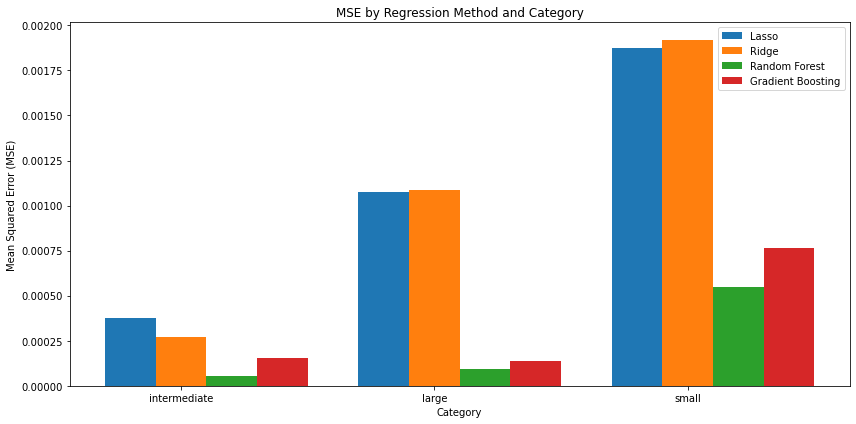

In [10]:
# Results from the four regression methods for "mse"
categories = lagged_df['category'].unique()
mse_values = {
    'Lasso': [best_models_lasso[cat]['mse'] for cat in categories],
    'Ridge': [best_models_ridge[cat]['mse'] for cat in categories],
    'Random Forest': [best_models_random_forest[cat]['mse'] for cat in categories],
    'Gradient Boosting': [best_models_gradient_boosting[cat]['mse'] for cat in categories]
}

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(len(categories))

for i, (method, mse) in enumerate(mse_values.items()):
    ax.bar([x + i * bar_width for x in index], mse, bar_width, label=method)

ax.set_xlabel('Category')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE by Regression Method and Category')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

#### Conclusion
"Random Forest" is best performing regression technique for every category.

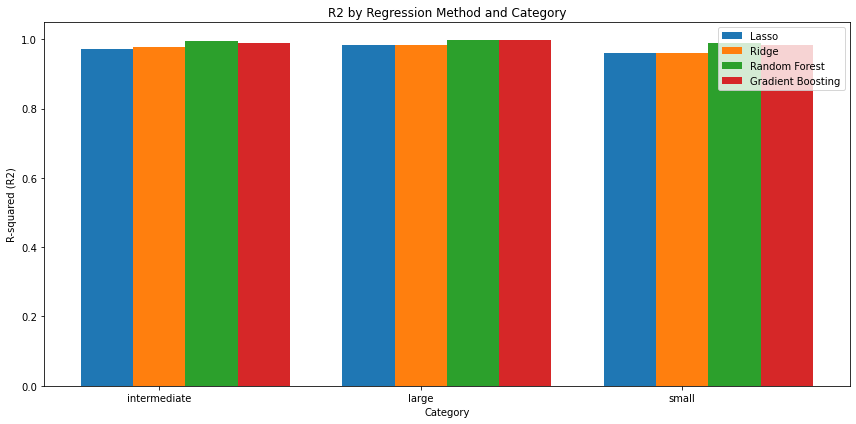

In [11]:
# Results from the four regression methods for "r2"
categories = lagged_df['category'].unique()
r2_values = {
    'Lasso': [best_models_lasso[cat]['r2'] for cat in categories],
    'Ridge': [best_models_ridge[cat]['r2'] for cat in categories],
    'Random Forest': [best_models_random_forest[cat]['r2'] for cat in categories],
    'Gradient Boosting': [best_models_gradient_boosting[cat]['r2'] for cat in categories]
}

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(len(categories))

for i, (method, r2) in enumerate(r2_values.items()):
    ax.bar([x + i * bar_width for x in index], r2, bar_width, label=method)

ax.set_xlabel('Category')
ax.set_ylabel('R-squared (R2)')
ax.set_title('R2 by Regression Method and Category')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

#### Conclusion
There isn't any significant difference among the regression techniques for every category

### Hypothesis Testing

#### Hypothesis I
Early warning signs can be identified in deposit data that indicate potential changes in non-maturity deposit levels. (Null hypothesis: deposit fluctuations are random and cannot be predicted based on historical data.)

To test the hypothesis, we can compare the evaluation metric (e.g., RMSE) of models with a baseline model (e.g., a model that predicts deposit fluctuations are random). If the evaluation metric of such as the Lasso regression or other model is significantly lower than the baseline model, it provides evidence to reject the null hypothesis.

A suitable baseline model might be a model that simply predicts the average deposit change or no change in deposits over time. This model assumes that deposit fluctuations are random and cannot be predicted, providing a benchmark for comparison with the Lasso regression or other models.

In [14]:
# Hypothesis I

def calculate_baseline_mse(lagged_df, category):
    """
    Calculate the baseline MSE for a given category.

    Args:
    - lagged_df (DataFrame): DataFrame containing the lagged data.
    - category (str): Category for which to calculate the baseline MSE.

    Returns:
    - float: Baseline MSE for the given category.
    """
    # Filter the DataFrame for the specified category
    category_df = lagged_df[lagged_df['category'] == category]

    # Calculate the baseline prediction (mean of total_deposits for the category)
    baseline_prediction = category_df['total_deposits'].mean()

    # Calculate the baseline MSE
    baseline_mse = mean_squared_error(category_df['total_deposits'], [baseline_prediction] * len(category_df))

    return baseline_mse

# Calculate baseline MSE for each category
for cat in lagged_df['category'].unique():
    baseline_mse = calculate_baseline_mse(lagged_df, cat)
    print(f"Category: {cat}")
    print(f"Baseline MSE: {baseline_mse}")
    print()

Category: intermediate
Baseline MSE: 0.016068493037059997

Category: large
Baseline MSE: 0.07099584667077205

Category: small
Baseline MSE: 0.06943043332295708



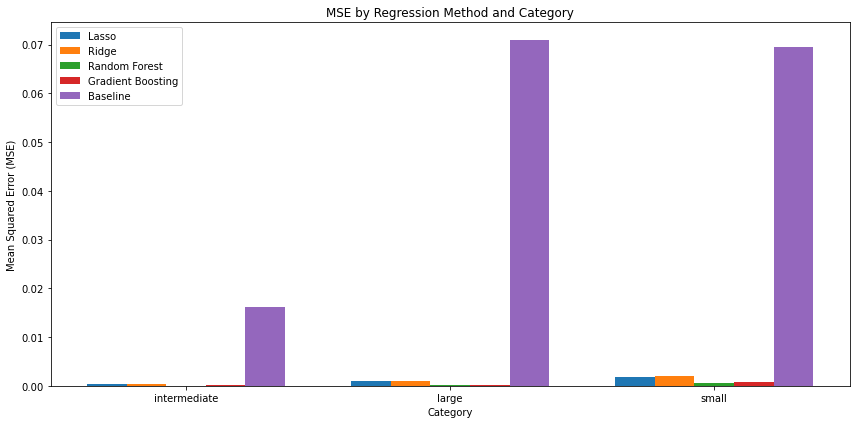

In [18]:
# Results from the four regression methods for "mse"
categories = lagged_df['category'].unique()
mse_values = {
    'Lasso': [best_models_lasso[cat]['mse'] for cat in categories],
    'Ridge': [best_models_ridge[cat]['mse'] for cat in categories],
    'Random Forest': [best_models_random_forest[cat]['mse'] for cat in categories],
    'Gradient Boosting': [best_models_gradient_boosting[cat]['mse'] for cat in categories],
    'Baseline': [calculate_baseline_mse(lagged_df, cat) for cat in categories]
}

# Create bar chart for MSE
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(categories))

for i, (method, mse) in enumerate(mse_values.items()):
    ax.bar(index + i * bar_width, mse, bar_width, label=method)

ax.set_xlabel('Category')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE by Regression Method and Category')
ax.set_xticks(index + 2 * bar_width)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

#### Conclusion
The evaluation metrics of models are significantly lower than the baseline model, it provides evidence to reject the null hypothesis which means deposit fluctuations are not random and can be predicted based on historical data

#### Hypothesis II
There are significant differences in deposit trends among different categories of banks by asset size.
(Null hypothesis: there are no significant differences between these categories).

To test this hypothesis, we can use ANOVA (Analysis of Variance) to determine if there are significant differences in deposit trends among different categories of banks by asset size.

In [13]:
# Hypothesis II:

def test_hypothesis_anova(lagged_df, selected_features):
    """
    Test the hypothesis using ANOVA.

    Args:
    - lagged_df (DataFrame): DataFrame containing the lagged data.
    - selected_features (list): List of selected features.

    Returns:
    - float: p-value from the ANOVA test.
    
    Decision Rule:
    - If the p-value is less than the significance level (e.g., 0.05), reject the null hypothesis
      and conclude that there are significant differences in deposit trends among different categories
      of banks by asset size. Otherwise, fail to reject the null hypothesis.
    """
    # Create a dictionary to store the data for each category
    data_by_category = {}
    for cat in lagged_df['category'].unique():
        data_by_category[cat] = lagged_df[lagged_df['category'] == cat]['total_deposits']

    # Perform ANOVA
    result = f_oneway(*[data_by_category[cat] for cat in lagged_df['category'].unique()])

    return result.pvalue

p_value_anova = test_hypothesis_anova(lagged_df, selected_features)

p_value_anova

7.770135793423456e-12

#### Conclusion
p-value is less than the significance level (e.g., 0.05), therefore we reject the null hypothesis, and conclude that there are significant differences in deposit trends among different categories of banks by asset size.